In [15]:
import requests
import os
from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np
from owslib.wms import WebMapService
from io import BytesIO
import regex as re

#################################################
#                GET GOOGLE IMAGES              #
#################################################

def latlong_to_xy(lat, lon, zoom):
    '''
    Converts latitude and longitude to tile coordinates
    '''
    lonRad = math.radians(lon)
    latRad = math.radians(lat)
    columnIndex = lonRad
    rowIndex = math.log(math.tan(latRad) + (1.0 / math.cos(latRad)))
    columnNormalized = (1 + (columnIndex / math.pi)) / 2
    rowNormalized = (1 - (rowIndex / math.pi)) / 2
    tilesPerRow = 2 ** zoom
    column = round(columnNormalized * (tilesPerRow - 1))
    row = round(rowNormalized * (tilesPerRow - 1))

    # ' -1' takes a square in the middle of a 3x3 grid
    return [column - 1, row - 1]

def download_tile(x, y, z):
    '''
    Downloads a tile for the given x and y coordinates and zoom level.
    It is pretty slow as it downloads one tile at a time
    '''
    url = "https://khms.google.com/kh/v=908?x=" + str(x) + "&y=" + str(y) + "&z=" + str(z)
    response = requests.get(url)
    bytes_io = BytesIO(response.content)
    PIL_image = Image.open(bytes_io)
    return PIL_image

def dl_square(x, y, z, size=3):
    '''
    Downloads a square of tiles, might add other shapes later
    '''
    imgs = {}
    max_x = x + size - 1
    max_y = y + size - 1
    y2 = y

    while x <= max_x:
        while y <= max_y:
            imgs[f"{x}_{y}"] = download_tile(x, y, z)
            y += 1
        y = y2
        x += 1

    return imgs

def stitch_tiles(imgs, x, y, size=3, img_size=256):
    '''
    Stitches tiles into one large image
    '''

    # Stitched image size
    width = size * img_size
    height = size * img_size

    max_x = x + size - 1
    max_y = y + size - 1
    x2 = x
    y2 = y

    output = Image.new(mode = "RGB", size = (width, height))

    while x2 <= max_x:
        while y2 <= max_y:
            img = imgs[f"{x2}_{y2}"]
            position_x = (x2 - x) * img_size
            position_y = (y2 - y) * img_size
            output.paste(img, (position_x, position_y))
            y2 += 1

        y2 = y
        x2 += 1

    return output

def calculate_zoom(lat: float):
    '''
    Defines the zoom level closest to 10 meters per pixel
    156543.03392 * Math.cos(latLng.lat() * Math.PI / 180) / Math.pow(2, zoom)
    '''
    meters_per_pixel = 10
    zoom = round(math.log(156543.03392 * math.cos(lat * math.pi / 180) / meters_per_pixel, 2), 0)
    return int(zoom)

def calc_meters_per_pixel(lat, zoom):
    '''
    Calculates how many meters are represented in one pixel
    '''
    return (156543.03392 * math.cos(lat * math.pi / 180) / (2 ** zoom))

def image_resize(meters_per_pixel, img):
    '''
    Resizes image to adjust the ratio to 10 meters per pixel
    '''
    pixels = img.height
    total_meters = meters_per_pixel*pixels
    new_size = int(round(total_meters/10,0))
    new_size = (new_size, new_size)
    return img.resize(new_size)

def image_crop(img):
    '''
    Crops the image to adjust size to 640 pixels
    '''
    # crop_pix = int(img.height / 64) * 64
    # return img.crop((0,0,crop_pix,crop_pix))
    crop_start = int((img.height-640)/2)
    crop_end = crop_start + 640
    return img.crop((crop_start, crop_start, crop_end, crop_end))
    

def get_google_image(lat:float, lon:float):
    """
    Given the GPS coordinate, retuns an RGB image from google maps
    centered around the given point with resolution of 10m/pixel.

    Arguments:
        lat: latitude of the central point (float)
        lon: longitude of the central point (float)

    Returns:
        An RGB image stored in a PIL.Image
    """
    zoom = calculate_zoom(lat)
    coords = latlong_to_xy(lat, lon, zoom)
    imgs = dl_square(coords[0], coords[1], zoom)
    stitched_image = stitch_tiles(imgs, coords[0], coords[1])
    meters_per_pixel = calc_meters_per_pixel(lat, zoom)

    img = image_resize(meters_per_pixel, stitched_image)
    img = image_crop(img)

    return img

#################################################
#                GET S2MAPS IMAGES             #
#################################################

def get_s2maps_data(lat:float, lon:float, year:str, size_km:float=6.4) -> Image:
    """
    Given the image side size in km and a GPS coordinate, retuns an RGB image centered
    in the given point with resolution of 10m/pixel

    Arguments:
        size_km: size of the image side in km (float)
        lat: latitude of the central point (float)
        lon: longitude of the central point (float)
        year: year of historical data, 4 options among [2017,2018,2019,2020]

    Returns:
        An RGB image stored in a PIL.Image

    """
    url = 'https://tiles.maps.eox.at/wms?service=wms&request=getcapabilities'
    wms = WebMapService(url)

    bbox = get_bounding_box(lat, lon, size_km/2)

    # Get new image
    pixels = int(size_km * 100)

    response = wms.getmap(
        layers=[f"s2cloudless-{year}"],
        size=[pixels, pixels],
        srs="EPSG:4326",
        #Bounding box for map extent. Value is minx,miny,maxx,maxy in units of the SRS. Left, bottom, right, top
        bbox=[bbox.lon_min, bbox.lat_min, bbox.lon_max, bbox.lat_max],
        format="image/jpeg")

    bytes_io = BytesIO(response.read())
    PIL_image = Image.open(bytes_io)
    return PIL_image

class BoundingBox(object):
    """
    Store 2 GPS points to create a bounding box
    """
    def __init__(self, *args, **kwargs):
        self.lat_min = None
        self.lon_min = None
        self.lat_max = None
        self.lon_max = None

def get_bounding_box(latitude_in_degrees : float, longitude_in_degrees : float, half_side_in_km : float):
    """
    Create a bounding box with size 'half_side_in_km' * 2 from a central GPS point

    Arguments:
        latitude_in_degrees: latitude of the central point (float)
        longitude_in_degrees: longitude of the central point (float)
        half_side_in_km: half of the size of the new image in km

    Returns:
        a BoundingBox object with the two new GPS points

    """
    assert half_side_in_km > 0
    assert latitude_in_degrees >= -90.0 and latitude_in_degrees  <= 90.0
    assert longitude_in_degrees >= -180.0 and longitude_in_degrees <= 180.0

    lat = math.radians(latitude_in_degrees)
    lon = math.radians(longitude_in_degrees)

    radius  = 6371
    # Radius of the parallel at given latitude
    parallel_radius = radius*math.cos(lat)

    lat_min = lat - half_side_in_km/radius
    lat_max = lat + half_side_in_km/radius
    lon_min = lon - half_side_in_km/parallel_radius
    lon_max = lon + half_side_in_km/parallel_radius
    rad2deg = math.degrees

    box = BoundingBox()
    box.lat_min = rad2deg(lat_min)
    box.lon_min = rad2deg(lon_min)
    box.lat_max = rad2deg(lat_max)
    box.lon_max = rad2deg(lon_max)

    return (box)

#################################################
#                COMMON FUNCTIONS               #
#################################################

def address_to_coord(address):
    '''
    Returns the latitude and longitude for a given address
    '''
    latlon = re.search(r'\-?\d+\.?\d*\s*,\s*\-?\d+\.?\d*', address)
    if latlon != None:
        text = latlon.string
        text = text.split(',')
        lat = float(text[0].strip())
        longi = float(text[1].strip())
    else:
        url = 'https://nominatim.openstreetmap.org/search'
        #'q' is for query --> look at hte documentation
        params = {'q': address, 'format': 'json'}
        response = requests.get(url, params = params).json()
        lat = float(response[0]['lat'])
        longi = float(response[0]['lon'])

    return lat, longi

def get_new_image(adr:str, year:str) -> Image:
    """
    Given the address or GPS coordinate, retuns an RGB image from google maps
    or from s2maps depending on the requested year centered around the given point with resolution of 10m/pixel.

    Arguments:
        lat: latitude of the central point (float)
        lon: longitude of the central point (float)

    Returns:
        An RGB image stored in a PIL.Image
    """

    lat, lon = address_to_coord(adr)

    if year == 'Google':
        return get_google_image(lat, lon)
    else:
        return get_s2maps_data(lat, lon, year)

def split_tiles(img : Image) -> np.array:
    """
    Given a big image, crop it into small images (tiles) of 64x64 pixels
    """

    tiles = []
    quads = int(img.height/64)

    for j in range(quads):
        for i in range(quads):
            temp_tile = np.array(img.crop((i*64, j*64, i*64+64, j*64+64)))
            tiles.append(temp_tile)
    return np.array(tiles)


In [17]:
address = 'nanterre'
year = 'Google'

img = get_new_image(address, year)
img.size

(640, 640)

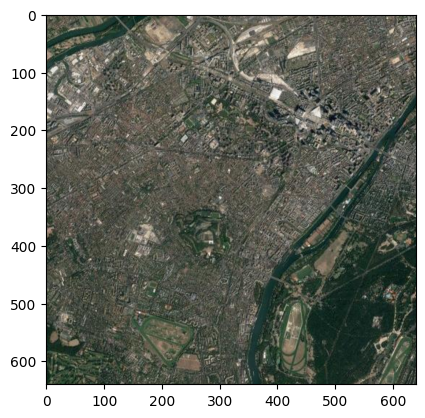

In [18]:
plt.imshow(img)